In [10]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 8.0.129, 8.0.174, 8.0.177, 8.1.21, 8.1.31, 8.2.7, 8.2.47
ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0.27 Requires-Python >=3.7,<=3.11; 8.0.28 Requires-Python >=3.7,<=3.11; 8.0.29 Requires-Python >=3.7,<=3.11; 8.0.30 Requires-Python >=3.7,<=3.11; 8.0.31 Requires-Python >=3.7,<=3.11; 8.0.

In [11]:
# ===== CELL 1: Import Libraries =====
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [12]:
# ===== CELL 2: Setup Paths =====
# Đường dẫn đến dataset
BASE_DIR = Path('F:\pr\data')  # Thư mục hiện tại
IMAGES_DIR = BASE_DIR / 'images'
LABELS_DIR = BASE_DIR / 'labels'
DATASET_YAML = BASE_DIR / 'dataset.yaml'

# Kiểm tra cấu trúc thư mục
print("📁 Dataset Structure:")
print(f"Images folder exists: {IMAGES_DIR.exists()}")
print(f"Labels folder exists: {LABELS_DIR.exists()}")
print(f"Dataset YAML exists: {DATASET_YAML.exists()}")

# Liệt kê các thư mục con
if IMAGES_DIR.exists():
    print(f"\nImages subfolders: {[d.name for d in IMAGES_DIR.iterdir() if d.is_dir()]}")
if LABELS_DIR.exists():
    print(f"Labels subfolders: {[d.name for d in LABELS_DIR.iterdir() if d.is_dir()]}")

📁 Dataset Structure:
Images folder exists: True
Labels folder exists: True
Dataset YAML exists: True

Images subfolders: ['train', 'val']
Labels subfolders: ['train', 'val']


In [13]:
# ===== CELL 3: Load Dataset Configuration =====
def load_dataset_config(yaml_path):
    """Load và hiển thị thông tin dataset từ YAML file"""
    with open(yaml_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)
    return config

# Load config
config = load_dataset_config(DATASET_YAML)

print("📋 Dataset Configuration:")
print(f"Train path: {config.get('train', 'Not specified')}")
print(f"Val path: {config.get('val', 'Not specified')}")
print(f"Number of classes: {config.get('nc', 'Not specified')}")
print(f"Class names: {config.get('names', [])}")

📋 Dataset Configuration:
Train path: images/train/
Val path: images/val/
Number of classes: 2
Class names: ['BSD', 'BSV']


In [14]:
# ===== CELL 4: Data Statistics =====
def count_images_and_labels(split='train'):
    """Đếm số lượng images và labels"""
    images_path = IMAGES_DIR / split
    labels_path = LABELS_DIR / split
    
    num_images = len(list(images_path.glob('*.jpg'))) + len(list(images_path.glob('*.png')))
    num_labels = len(list(labels_path.glob('*.txt')))
    
    return num_images, num_labels

# Thống kê train set
train_imgs, train_lbls = count_images_and_labels('train')
print(f"📊 TRAIN SET:")
print(f"  - Images: {train_imgs}")
print(f"  - Labels: {train_lbls}")
print(f"  - Match: {'✅' if train_imgs == train_lbls else '❌'}")

# Thống kê val set
val_imgs, val_lbls = count_images_and_labels('val')
print(f"\n📊 VALIDATION SET:")
print(f"  - Images: {val_imgs}")
print(f"  - Labels: {val_lbls}")
print(f"  - Match: {'✅' if val_imgs == val_lbls else '❌'}")

# Tổng quan
print(f"\n📈 TOTAL:")
print(f"  - Total images: {train_imgs + val_imgs}")
print(f"  - Train/Val ratio: {train_imgs/(train_imgs+val_imgs)*100:.1f}% / {val_imgs/(train_imgs+val_imgs)*100:.1f}%")

📊 TRAIN SET:
  - Images: 3433
  - Labels: 3433
  - Match: ✅

📊 VALIDATION SET:
  - Images: 1145
  - Labels: 1145
  - Match: ✅

📈 TOTAL:
  - Total images: 4578
  - Train/Val ratio: 75.0% / 25.0%


In [15]:
# ===== CELL 5: Analyze Label Format =====
def read_yolo_label(label_path):
    """Đọc YOLO label file"""
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    annotations = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            annotations.append({
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
    return annotations

# Kiểm tra một file label mẫu
sample_label = list((LABELS_DIR / 'train').glob('*.txt'))[0]
print(f"🔍 Sample label file: {sample_label.name}")
print(f"Content:")
with open(sample_label, 'r') as f:
    print(f.read())

# Parse annotations
annotations = read_yolo_label(sample_label)
print(f"\n📝 Parsed annotations:")
for i, ann in enumerate(annotations, 1):
    print(f"  Object {i}: Class={ann['class_id']}, BBox=({ann['x_center']:.3f}, {ann['y_center']:.3f}, {ann['width']:.3f}, {ann['height']:.3f})")

🔍 Sample label file: carlong_0001.txt
Content:
0 0.2990083905415713 0.5732265446224256 0.5163996948893974 0.5528858377828629 0.5194508009153318 0.6189931350114417 0.2990083905415713 0.6464530892448512


📝 Parsed annotations:
  Object 1: Class=0, BBox=(0.299, 0.573, 0.516, 0.553)


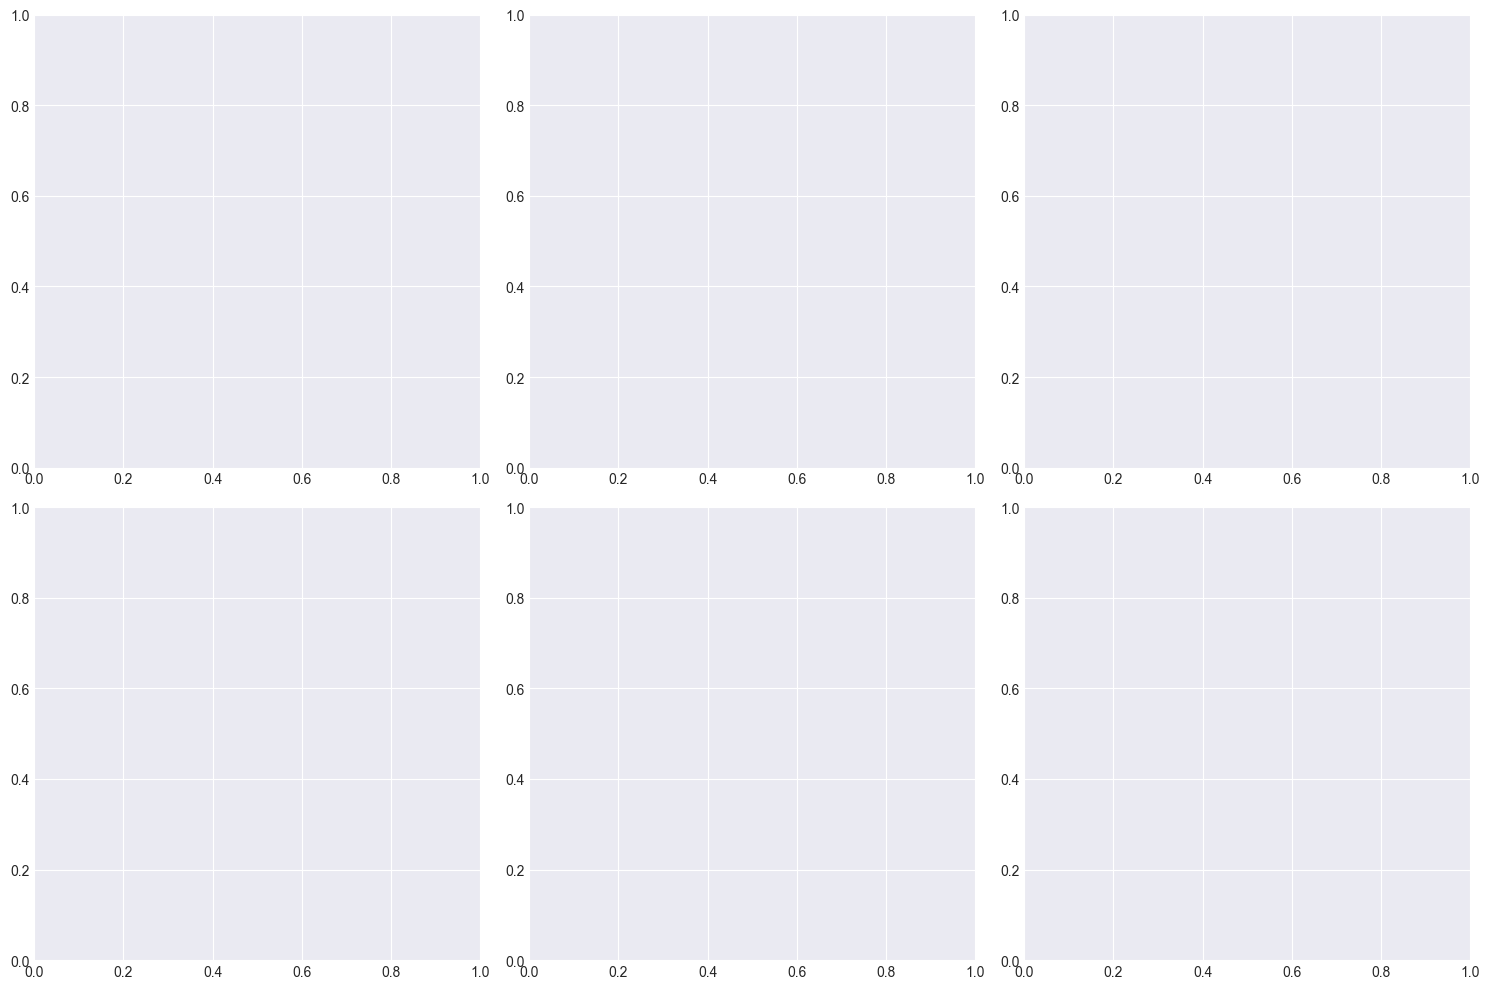

✅ Visualization saved as 'sample_annotations.png'


In [16]:
# ===== CELL 6: Visualize Sample Images with Annotations =====
def visualize_image_with_bbox(image_path, label_path, class_names):
    """Hiển thị ảnh với bounding boxes"""
    # Đọc ảnh
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Đọc annotations
    annotations = read_yolo_label(label_path)
    
    # Vẽ bounding boxes
    for ann in annotations:
        # Convert YOLO format to pixel coordinates
        x_center = ann['x_center'] * w
        y_center = ann['y_center'] * h
        box_w = ann['width'] * w
        box_h = ann['height'] * h
        
        x1 = int(x_center - box_w/2)
        y1 = int(y_center - box_h/2)
        x2 = int(x_center + box_w/2)
        y2 = int(y_center + box_h/2)
        
        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Draw label
        label = class_names[ann['class_id']] if ann['class_id'] < len(class_names) else f"Class {ann['class_id']}"
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return img

# Hiển thị 6 ảnh mẫu
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

train_images = list((IMAGES_DIR / 'train').glob('*.jpg'))[:6]
class_names = config.get('names', ['license_plate'])

for idx, img_path in enumerate(train_images):
    label_path = LABELS_DIR / 'train' / (img_path.stem + '.txt')
    
    if label_path.exists():
        img_with_bbox = visualize_image_with_bbox(img_path, label_path, class_names)
        axes[idx].imshow(img_with_bbox)
        axes[idx].set_title(f"{img_path.name}", fontsize=10)
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('sample_annotations.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Visualization saved as 'sample_annotations.png'")

In [17]:
# ===== CELL 7: Analyze BBox Statistics =====
def analyze_bbox_statistics(split='train'):
    """Phân tích thống kê về bounding boxes"""
    labels_path = LABELS_DIR / split
    images_path = IMAGES_DIR / split
    
    bbox_widths = []
    bbox_heights = []
    bbox_areas = []
    bbox_aspect_ratios = []
    objects_per_image = []
    
    for label_file in labels_path.glob('*.txt'):
        # Get corresponding image
        img_file = images_path / (label_file.stem + '.jpg')
        if not img_file.exists():
            img_file = images_path / (label_file.stem + '.png')
        
        if img_file.exists():
            img = cv2.imread(str(img_file))
            h, w = img.shape[:2]
            
            annotations = read_yolo_label(label_file)
            objects_per_image.append(len(annotations))
            
            for ann in annotations:
                bbox_w = ann['width'] * w
                bbox_h = ann['height'] * h
                
                bbox_widths.append(bbox_w)
                bbox_heights.append(bbox_h)
                bbox_areas.append(bbox_w * bbox_h)
                bbox_aspect_ratios.append(bbox_w / bbox_h if bbox_h > 0 else 0)
    
    return {
        'widths': bbox_widths,
        'heights': bbox_heights,
        'areas': bbox_areas,
        'aspect_ratios': bbox_aspect_ratios,
        'objects_per_image': objects_per_image
    }

# Phân tích train set
print("🔬 Analyzing bounding box statistics...")
train_stats = analyze_bbox_statistics('train')

print(f"\n📊 BOUNDING BOX STATISTICS (Train Set):")
print(f"  Total bounding boxes: {len(train_stats['widths'])}")
print(f"\n  Width (pixels):")
print(f"    - Mean: {np.mean(train_stats['widths']):.2f}")
print(f"    - Std: {np.std(train_stats['widths']):.2f}")
print(f"    - Min: {np.min(train_stats['widths']):.2f}")
print(f"    - Max: {np.max(train_stats['widths']):.2f}")
print(f"\n  Height (pixels):")
print(f"    - Mean: {np.mean(train_stats['heights']):.2f}")
print(f"    - Std: {np.std(train_stats['heights']):.2f}")
print(f"    - Min: {np.min(train_stats['heights']):.2f}")
print(f"    - Max: {np.max(train_stats['heights']):.2f}")
print(f"\n  Aspect Ratio (W/H):")
print(f"    - Mean: {np.mean(train_stats['aspect_ratios']):.2f}")
print(f"    - Std: {np.std(train_stats['aspect_ratios']):.2f}")
print(f"\n  Objects per image:")
print(f"    - Mean: {np.mean(train_stats['objects_per_image']):.2f}")
print(f"    - Max: {np.max(train_stats['objects_per_image'])}")

🔬 Analyzing bounding box statistics...

📊 BOUNDING BOX STATISTICS (Train Set):
  Total bounding boxes: 3887

  Width (pixels):
    - Mean: 255.54
    - Std: 185.71
    - Min: 0.62
    - Max: 4008.00

  Height (pixels):
    - Mean: 194.87
    - Std: 150.71
    - Min: 0.00
    - Max: 2824.50

  Aspect Ratio (W/H):
    - Mean: 1.84
    - Std: 3.82

  Objects per image:
    - Mean: 1.13
    - Max: 9


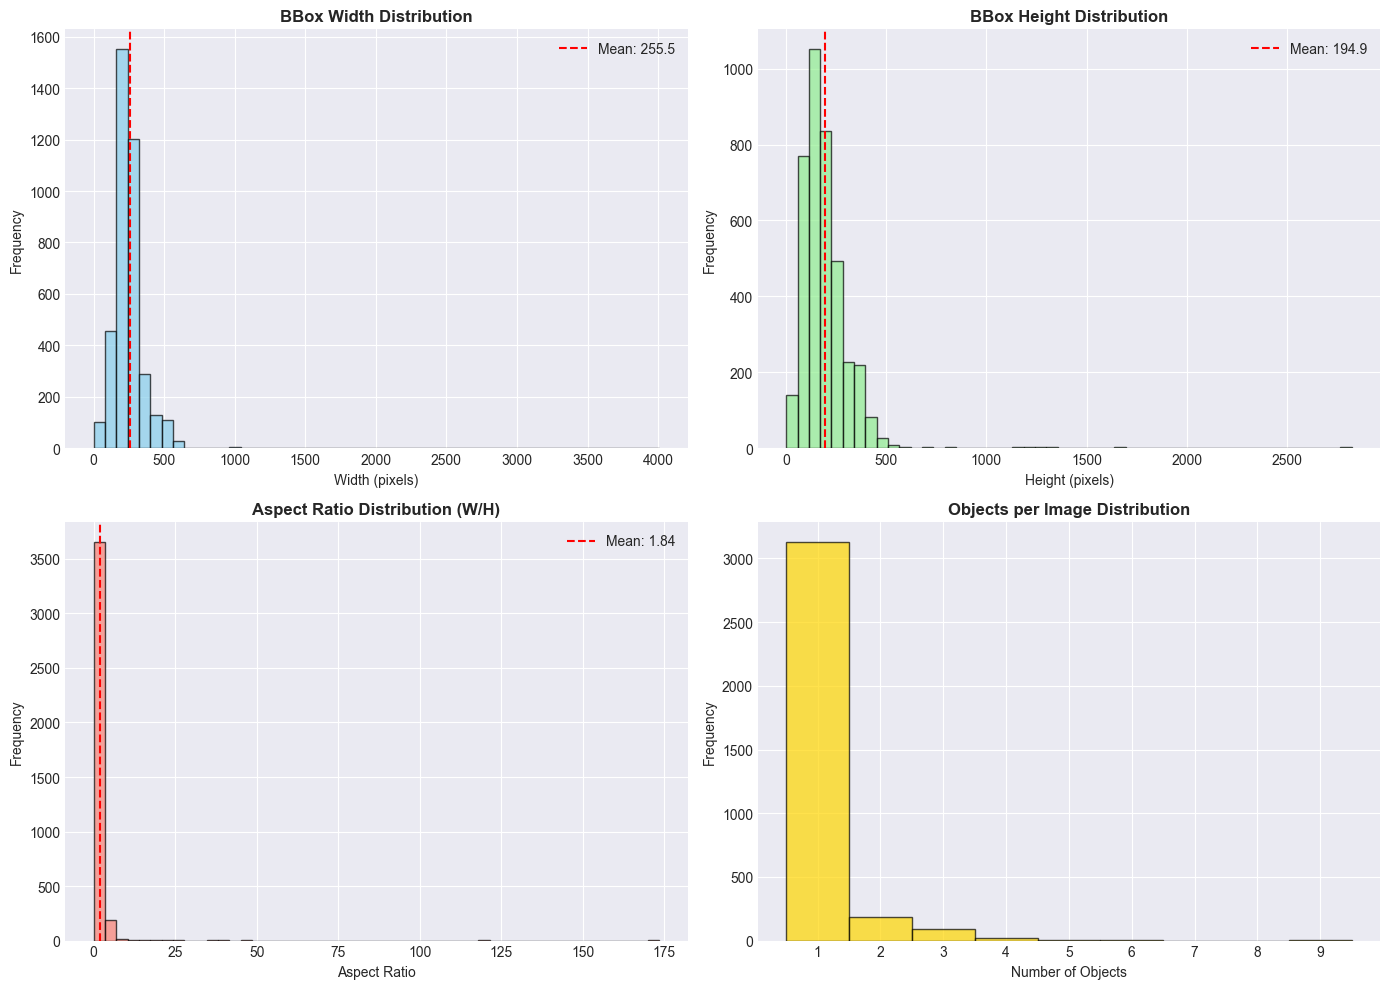

✅ Statistics visualization saved as 'bbox_statistics.png'


In [18]:
# ===== CELL 8: Visualize Statistics =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# BBox Width distribution
axes[0, 0].hist(train_stats['widths'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('BBox Width Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.mean(train_stats['widths']), color='red', linestyle='--', label=f"Mean: {np.mean(train_stats['widths']):.1f}")
axes[0, 0].legend()

# BBox Height distribution
axes[0, 1].hist(train_stats['heights'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('BBox Height Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.mean(train_stats['heights']), color='red', linestyle='--', label=f"Mean: {np.mean(train_stats['heights']):.1f}")
axes[0, 1].legend()

# Aspect Ratio distribution
axes[1, 0].hist(train_stats['aspect_ratios'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Aspect Ratio Distribution (W/H)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.mean(train_stats['aspect_ratios']), color='red', linestyle='--', label=f"Mean: {np.mean(train_stats['aspect_ratios']):.2f}")
axes[1, 0].legend()

# Objects per image
axes[1, 1].hist(train_stats['objects_per_image'], bins=range(1, max(train_stats['objects_per_image'])+2), 
                color='gold', edgecolor='black', alpha=0.7, align='left')
axes[1, 1].set_title('Objects per Image Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Objects')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xticks(range(1, max(train_stats['objects_per_image'])+1))

plt.tight_layout()
plt.savefig('bbox_statistics.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Statistics visualization saved as 'bbox_statistics.png'")